<div align="center">
    <img src='../../xepimage.png' style='height:100px;'>
</div>


<center><h1 style='font-size:25px'>Model</h1></center>

---

**Autor: Guillermo J. Bergues**

AutoluOn model for Xepelin project.

Data = basic (first approach).

In [1]:
pip install autogluon

In [2]:
import pandas as pd 
import numpy as np

from autogluon.tabular import TabularPredictor, TabularDataset

# Metrics
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../../Data/ds_basic.csv')

In [4]:
df.head()

,PayerId,ReceiverId,days,amount,amountfinancedByXepelin
0,151,19,0,1490.46,0.00
1,126,18,0,920.26,0.00
2,114,37,7,4035.26,0.00
3,122,12,10,27979.20,10520.15
4,55,34,22,1477.46,0.00


<AxesSubplot:>

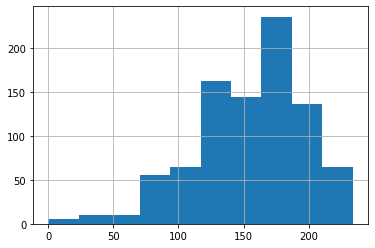

In [5]:
df['days'].hist()

In [6]:
save_path = "agModels"

In [7]:
df_train = df[df["days"] < 180]

In [8]:
label = 'amount'

In [9]:
df_train = TabularDataset(df)

In [10]:
# Metric for optimization MAE
predictor = TabularPredictor(label=label, path=save_path, eval_metric='median_absolute_error').fit(df_train, time_limit=18000)

Beginning AutoGluon training ... Time limit = 18000s
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.4.2
Python Version:     3.8.10
Operating System:   Linux
Train Data Rows:    892
Train Data Columns: 4
Label Column: amount
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3370741.92, 58.16, 30752.25663, 154172.74947)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    64866.19 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manu

In [11]:
test_data = df[df["days"] >= 180]

In [12]:
df_test = TabularDataset(test_data)

In [13]:
# values to predict
y_test = df_test[label]  

In [14]:
# delete label column to prove we're not cheating
test_data_nolab = df_test.drop(columns=[label])  

In [15]:
test_data_nolab.head()

,PayerId,ReceiverId,days,amountfinancedByXepelin
628,187,55,182,0.0
629,174,82,182,0.0
630,145,42,183,0.0
631,138,44,183,0.0
632,169,38,183,0.0


In [16]:
predictor = TabularPredictor.load(save_path)  

In [17]:
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)

Predictions:  
 628    1369.259644
629    1357.518677
630    2271.319092
631    2273.572021
632    1380.713013
          ...     
887    1447.433960
888    1519.357422
889    1507.569336
890    1393.896118
891    1394.450562
Name: amount, Length: 264, dtype: float32


In [18]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: median_absolute_error on test data: -291.5165161132812
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "median_absolute_error": -291.5165161132812,
    "root_mean_squared_error": -32700.21812527079,
    "mean_squared_error": -1069304265.4402882,
    "mean_absolute_error": -9565.182551713424,
    "r2": 0.6873496603624003,
    "pearsonr": 0.9170478762304354
}


In [19]:
# Predictions and test data set
df_test_pred = pd.concat([y_test, y_pred], axis=1)
df_test_pred.columns = ['test', 'prediction']
df_test_pred['residual'] = df_test_pred['test'] - df_test_pred['prediction']
df_test_pred.head()

,test,prediction,residual
628,725.46,1369.259644,-643.799644
629,1792.46,1357.518677,434.941323
630,1139.86,2271.319092,-1131.459092
631,2052.66,2273.572021,-220.912021
632,1447.86,1380.713013,67.146987


Text(0, 0.5, 'Predicted Y')

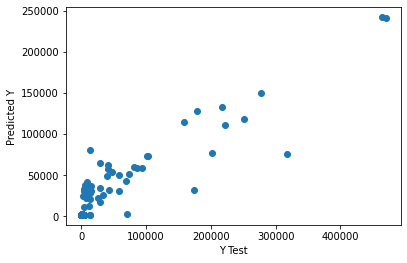

In [20]:
sns.regplot(x=y_test, y=y_pred);
plt.xlabel('Test values')
plt.ylabel('Predicted values')

In [21]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,-0.000039,-988.986118,0.008790,0.006848,0.004623,0.008790,0.006848,0.004623,1,True,2
1,RandomForestMSE,-236.845176,-1012.825942,0.087763,0.068770,0.651890,0.087763,0.068770,0.651890,1,True,5
2,XGBoost,-247.035073,-349.035073,0.009643,0.005715,0.515058,0.009643,0.005715,0.515058,1,True,9
3,WeightedEnsemble_L2,-291.516516,-309.940298,0.053724,0.023570,2.345840,0.004483,0.000452,0.325700,2,True,12
4,ExtraTreesMSE,-341.120293,-1106.036826,0.087782,0.068541,0.613682,0.087782,0.068541,0.613682,1,True,7
5,KNeighborsUnif,-396.011975,-862.500059,0.008788,0.009425,0.006803,0.008788,0.009425,0.006803,1,True,1
6,LightGBMLarge,-486.793311,-1631.023535,0.016432,0.003880,0.928595,0.016432,0.003880,0.928595,1,True,11
7,CatBoost,-1166.653303,-1772.694629,0.005143,0.002114,4.203658,0.005143,0.002114,4.203658,1,True,6
8,LightGBM,-1176.950518,-2074.578867,0.006533,0.002819,0.374464,0.006533,0.002819,0.374464,1,True,4
9,NeuralNetTorch,-1621.456528,-1331.839609,0.030811,0.007977,1.498279,0.030811,0.007977,1.498279,1,True,10


In [22]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 9565.182551713424
MSE: 1069304265.4402882
RMSE: 32700.21812527079


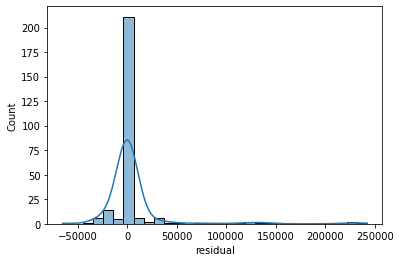

In [23]:
# Distributions of residuals
sns.histplot(data=df_test_pred, x='residual', kde=True, bins=30);

In [24]:
f_importance = predictor.feature_importance(df_test)
f_importance.head()

Computing feature importance via permutation shuffling for 4 features using 264 rows with 5 shuffle sets...
	1.34s	= Expected runtime (0.27s per shuffle set)
	0.46s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
amountfinancedByXepelin,254.655390,82.909893,0.001177,5,425.368005,83.942775
PayerId,25.247408,35.724199,0.094595,5,98.804027,-48.309211
ReceiverId,18.421281,31.400703,0.129906,5,83.075763,-46.233201
days,6.672455,4.778088,0.017719,5,16.510604,-3.165695
